## Introduction

The goal of this notebook is to build a model (presumably consisting of a neural network) that will be able to classify the genre of a song. 
The first important tool in this regard is the python library [Librosa](https://librosa.github.io/librosa/). As explained in the README for this 
repo, this tool lets us import data from `.wav` or `.mp3` files, which are some of the most common filetypes for audio. 
I will be using data from the [Free Music Archive](https://github.com/mdeff/fma).

When Librosa loads an audio file, there is a default sample rate, which is the number of samples from the mp3's audio signal for one second. Therefore,
to get the length of a song in real time we take the length of the read-in array and divide by the sample rate for that audio sample.

In [1]:
# system packages
import os
import glob
import warnings

warnings.filterwarnings(action='ignore')

# usual imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# tensorflow and keras
# import tensorflow as tf
# from tensorflow.keras.layers import (
#     Dense,
#     Activation,
#     Flatten,
#     Conv1D,
#     Conv2D,
#     BatchNormalization,
#     MaxPooling1D,
#     MaxPooling2D,
#     Dropout,
#     Reshape,
#     LSTM,
# )
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
# from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
# from sklearn.metrics import confusion_matrix, classification_report

## audio tools
import librosa
from torchaudio import info

# my functions and classes
from utilities import (
    view_melspec,
    read_metadata_file,
    Batch_generator,
    id_from_path,
    attach_onehot_encoding,
    mp3_to_mel_path,
    plot_sample,
)

# VERY GLOBAL VARIABLES
audio_dir = "./data/fma_small/"
global_dur = 2.0
global_sr = 22050

 # Searches for every mp3 file within a directory. Especially helpful for the FMA dataset.
filepaths = librosa.util.files.find_files(audio_dir)

## Understanding Audio Data

When we hear sounds we are sensing vibrations in the air around us. This can be represented by a _waveform_ that describes exactly how that air is vibrating. These waveforms are what the various audio files are storing.
Here is a look at the waveform.

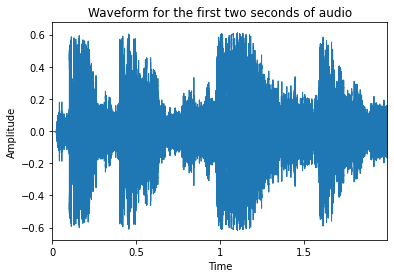

In [2]:
# Load will produce the waveform and the sample rate as an output.
example_source, example_sr = librosa.load(filepaths[1], sr=global_sr, duration=global_dur)

librosa.display.waveplot(example_source, sr=example_sr)
plt.ylabel("Amplitude")
plt.title("Waveform for the first two seconds of audio")
plt.show()

Some terminology: the _sample rate_ (`sr`) is a number (measured in Hz) telling us how many times per second the true audio waveform was measured.
High quality audio usually has a sample rate of 44.1 kHz. 
If the audio is mono then Librosa hands you a numpy array of length `sr * duration`, and if the audio is stereo it hands you a 
two dimensional numpy array of shape (2, `sr * duration`).

In [3]:
print(f'The sample rate of the example audio is {example_sr} and duration {librosa.get_duration(example_source)}. This leads to a numpy array of length {int(example_sr * librosa.get_duration(example_source))}.')
print(f'Numpy array shape: {example_source.shape}')

The sample rate of the example audio is 22050 and duration 2.0. This leads to a numpy array of length 44100.
Numpy array shape: (44100,)


The entries in this numpy array are exactly the amplitudes of the waveform. If you were just to plot the numpy array, you get
the same waveform plot but indexed by the sample location instead of time.

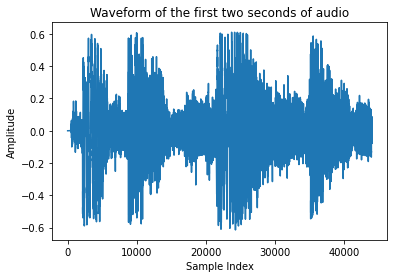

In [4]:
plt.plot(example_source)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Waveform of the first two seconds of audio')
plt.show()

Spectrograms are a different way of representing the information in a waveform. It selects out the frequencies of each chunk of audio 
using a Fourier transform. The result is a colorful image showing the intensity (dB) of each frequency over time. 
(This sometimes goes under the name of "Short-Time Fourier Transform," where a signal over an interval is subdivided into small chunks over subintervals and a Fourier transform is applied to each little chunk). 

A melspectrogram is essentially a spectrogram where the intensity of each frequency is logarithmically scaled and shifted. This brings the features of the audio closer together visually, which will help a lot in applying machine learning techniques. This can be thought of as a kind of normalization.

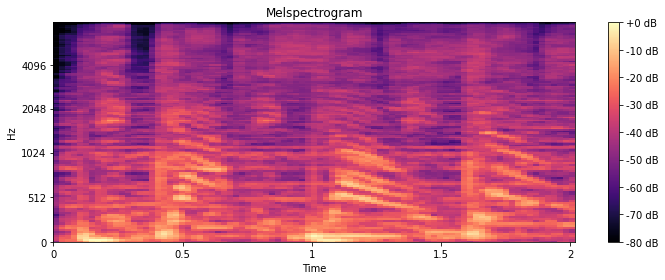

In [5]:
view_melspec(example_source, global_sr)

## How long does a typical load take?

Being a rather unfamiliar data type, it is good to get a sense of how much time it takes to load this data and how much memory it consumes by storing it.

On my 2013 Macbook Pro running Ubuntu, two seconds of audio takes about 384 ms to load. Since there are about 8000 songs in the small version of the FMA dataset, you can get an estimate for how long it would take to load every waveform in by multiplying 384 by 8 (the thousand cancels with the milli), which gives about 

In [6]:
print(f"Loading 2 seconds from all audio samples will take about {np.round(384* 8 /60, 2)} minutes.")

Loading 2 seconds from all audio samples will take about 51.2 minutes.


This is on an old macbook pro running a suboptimal operating system, so a newer computer may be able to handle this a lot better than my current one.

A challenge when working with audio data is that some files can be corrupted, and Librosa will return an error when loading them.
Rather than running through the entire dataset using `Librosa.load` we can instead use `torchaudio.info` which collects any metadata from the tracks without having to load each sample.

On my 2013 MBP this only takes about 150 microseconds, a dramatic improvement. The metadata preprocessing script uses this under the hood to check for integrity.

## Estimating memory cost

This takes about 1.4 GB of memory to store all song audio.

## Dataframe management

Be sure to run `metadata_preprocess.py` before running this cell. This just loads the processed metadata as a tidy dataframe.

In [10]:
meta_path = os.path.join(".", "data", "fma_metadata", "meta_df.csv")

meta_df = pd.read_csv(
    os.path.join(meta_path), index_col=0
)

# get a list of the genres
genre_list = list(meta_df.genre.unique())
genre_dict = dict(zip(genre_list, range(len(genre_list))))

In [11]:
## check to make sure each path points to the right file
meta_df["track_id"].equals(meta_df["mp3_path"].apply(lambda x: int(id_from_path(x))))

True

In [12]:
meta_df.head()

,track_id,genre,mp3_path,duration,mel_path
0,2,Hip-Hop,/home/andrew/Documents/projects/music_clf/data...,29.9,./data/fma_small_melspecs/000002.npz
1,5,Hip-Hop,/home/andrew/Documents/projects/music_clf/data...,30.0,./data/fma_small_melspecs/000005.npz
2,10,Pop,/home/andrew/Documents/projects/music_clf/data...,29.9,./data/fma_small_melspecs/000010.npz
3,140,Folk,/home/andrew/Documents/projects/music_clf/data...,29.9,./data/fma_small_melspecs/000140.npz
4,141,Folk,/home/andrew/Documents/projects/music_clf/data...,29.9,./data/fma_small_melspecs/000141.npz


## Duration Analysis

Most songs in the FMA dataset are around 30 seconds in length.

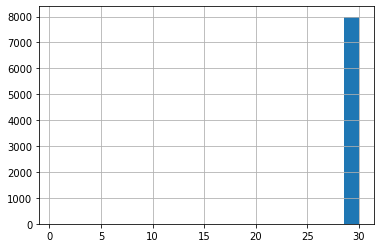

In [43]:
meta_df.duration.hist(bins=20)

However, there are a few that are very short.

In [13]:
meta_df.loc[(meta_df.duration < 28), :]

,track_id,genre,mp3_path,duration,mel_path
4423,98565,Hip-Hop,/home/andrew/Documents/projects/music_clf/data...,1.6,./data/fma_small_melspecs/098565.npz
4424,98567,Hip-Hop,/home/andrew/Documents/projects/music_clf/data...,0.5,./data/fma_small_melspecs/098567.npz
4425,98569,Hip-Hop,/home/andrew/Documents/projects/music_clf/data...,1.5,./data/fma_small_melspecs/098569.npz


I will be training models on samples at least 2 seconds long, so these will be dropped.

In [14]:
meta_df.drop(meta_df.loc[(meta_df.duration < 28), :].index, axis=0, inplace=True)

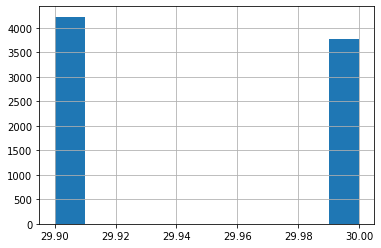

In [15]:
meta_df.duration.hist(bins=10)

## Encoding Genres

In [16]:
# encode genre column
if not set(genre_list).issubset(meta_df.columns):
    meta_df = attach_onehot_encoding(meta_df, "genre")

## Analyzing the preprocessing

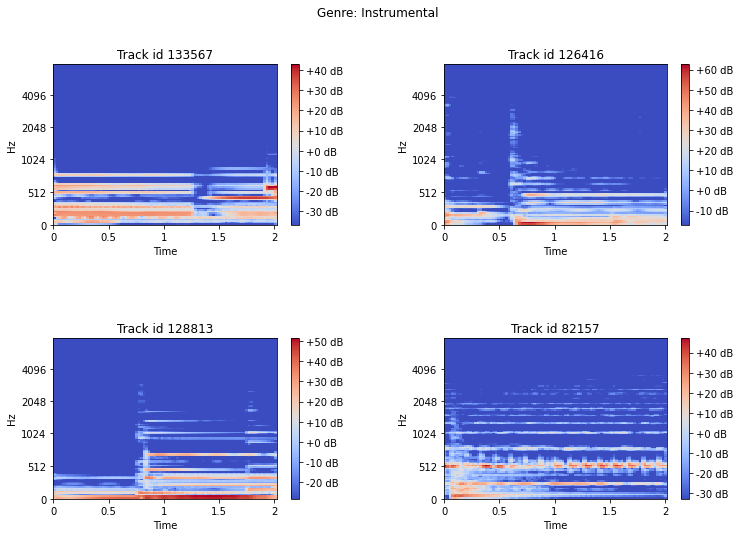

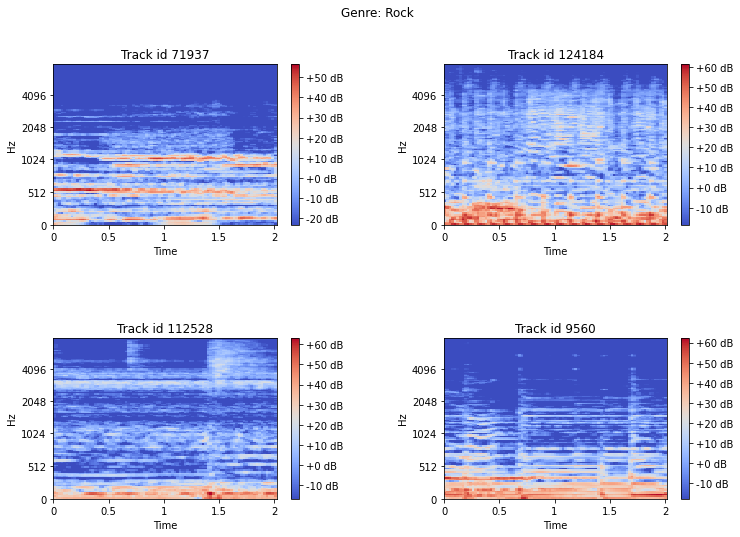

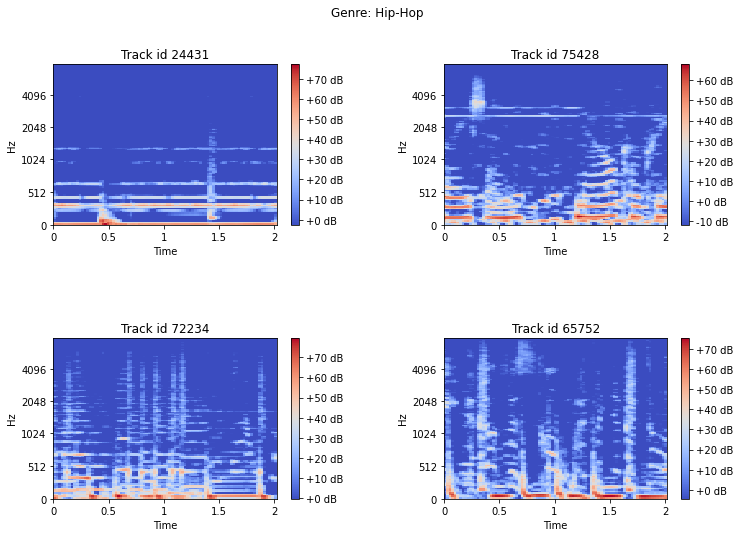

In [17]:
plot_sample("Instrumental", meta_df, nrow=2)
plot_sample("Rock", meta_df, nrow=2)
plot_sample("Hip-Hop", meta_df, nrow=2)

# Models

In [20]:
input_shape = np.load(meta_df["mel_path"].iloc[0])["arr_0"].shape + (1,)

In [21]:
class MyModel:
    """
    Wrapper class around my training, loading, and evaluation.
    """

    def __init__(
        self,
        batch_size,
        model_dir,
        input_shape=input_shape,
        params=None,
        meta_df=meta_df,
        genre_dict=genre_dict,
    ):
        self.batch_size = batch_size
        self.params = params
        self.genre_dict = genre_dict
        self.model_dir = model_dir

        self.model_path = glob.glob(os.path.join(model_dir, "*.h5"))
        ### Currently this will fail if there isn't already a file there.

        if self.model_path:
            self.model_path = self.model_path[0]
        else:
            self.model_path = os.path.join(self.model_dir, "model.h5")

        # 60 - 20 - 20 split
        self.train_gen = Batch_generator(
            meta_df.iloc[:4800, :],
            batch_size=self.batch_size,
            genre_dict=self.genre_dict,
        )
        self.valid_gen = Batch_generator(
            meta_df.iloc[4800:6400, :],
            batch_size=self.batch_size,
            genre_dict=self.genre_dict,
        )
        self.test_gen = Batch_generator(
            meta_df.iloc[6400:, :],
            batch_size=self.batch_size,
            genre_dict=self.genre_dict,
        )

        self.input_shape = input_shape

    def attach_model(self, model):
        self.model = model

    def load_model(self):
        """
        Loads the model from the model directory. Alternative to passing 
        a new model.
        """
        if os.path.exists(self.model_path):
            self.model = tf.keras.models.load_model(self.model_path)
        else:
            raise ValueError("File Not Found. Please train model.")

    def fit(self, num_epochs):
        checkpoint_callback = ModelCheckpoint(
            self.model_path,
            monitor="val_accuracy",
            verbose=1,
            save_best_only=True,
            mode="max",
        )
        reducelr_callback = ReduceLROnPlateau(
            monitor="val_accuracy", factor=0.5, patience=5, min_delta=0.01, verbose=1
        )
        early_stop = EarlyStopping(
            monitor="val_accuracy", patience=10, verbose=1, restore_best_weights=True
        )

        callbacks_list = [checkpoint_callback, reducelr_callback, early_stop]

        self.history = self.model.fit_generator(
            generator=self.train_gen,
            epochs=num_epochs,
            verbose=1,
            validation_data=self.valid_gen,
            callbacks=callbacks_list,
        )

    def summary(self):
        return self.model.summary()

    def _compile(self):
        self.model.compile(
            optimizer=Adam(lr=0.001),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

    def evaluate(self, verbose=0, all=False):

        if all:
            print("Training set")
            self.model.evaluate(self.train_gen, verbose=verbose),
            print("Validation set")
            self.model.evaluate(self.valid_gen, verbose=verbose),
            print("Testing set")
            self.model.evaluate(self.test_gen, verbose=verbose)
        else:
            print("Testing set")
            self.model.evaluate(self.test_gen, verbose=verbose)

    def plot_history(self):
        plt.plot(self.history.history["accuracy"])
        plt.plot(self.history.history["val_accuracy"])
        plt.title("Model accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Valid"], loc="upper left")
        plt.show()

        plt.savefig(os.path.join(self.model_dir, "last_training_acc.png"))

        # Plot training & validation loss values
        plt.plot(self.history.history["loss"])
        plt.plot(self.history.history["val_loss"])
        plt.title("Model loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Valid"], loc="upper left")
        plt.show()
        plt.savefig(os.path.join(self.model_dir, "last_training_loss.png"))

    def confusion_matrix(self, print_labels=True):

        y_pred = np.argmax(self.model.predict_generator(self.valid_gen), axis=1)
        classes = np.argmax(self.valid_gen.labels, axis=1)

        print(confusion_matrix(classes, y_pred))

    def classification_report(self):

        y_pred = np.argmax(self.model.predict_generator(self.valid_gen), axis=1)
        classes = np.argmax(self.valid_gen.labels, axis=1)

        print(
            classification_report(
                classes, y_pred, target_names=list(self.genre_dict.keys())
            )
        )

## Logistic Regression

It's worth it to see if we can train a logistic regression model and see how well it does at classifying the genres. 

In [22]:
logreg_path = "models/logreg/"
logistic_reg = MyModel(batch_size=16, model_dir=logreg_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5568)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5568)              22272     
_________________________________________________________________
dense (Dense)                (None, 8)                 44552     
Total params: 66,824
Trainable params: 55,688
Non-trainable params: 11,136
_________________________________________________________________
Epoch 1/50
298/300 [============================>.] - ETA: 0s - loss: 3.0941 - accuracy: 0.2001
Epoch 00001: val_accuracy improved from -inf to 0.19375, saving model to models/logreg/logreg.h5
300/300 [==============================] - 16s 52ms/step - loss: 3.0976 - accuracy: 0.1996 - val_loss: 2.9421 - val_accuracy: 0.1937
Epoch 2/50
298/300 [============================>.]

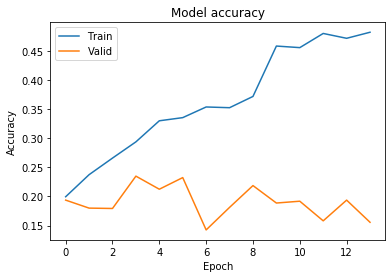

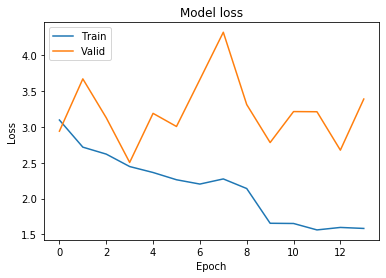

<Figure size 432x288 with 0 Axes>

In [23]:
logistic_reg_model = Sequential(
    [
        Flatten(data_format=None, input_shape=input_shape),
        BatchNormalization(),
        Dense(
            8,
            activation="softmax",
            #           kernel_regularizer=regularizers.l2(0.01)
        ),
    ]
)

logistic_reg.attach_model(logistic_reg_model)
logistic_reg._compile()
logistic_reg.summary()
logistic_reg.fit(num_epochs=50)
logistic_reg.plot_history()

In [24]:
logistic_reg.load_model()
logistic_reg.summary()
# logistic_reg.evaluate(verbose=1, all=True)
logistic_reg.confusion_matrix()
logistic_reg.classification_report()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5568)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5568)              22272     
_________________________________________________________________
dense (Dense)                (None, 8)                 44552     
Total params: 66,824
Trainable params: 55,688
Non-trainable params: 11,136
_________________________________________________________________
[[ 49  10   5   6  18   1  72   4]
 [ 35  13  16  15  53  13  22   3]
 [ 14  18  39  27  16  15  11   2]
 [ 15  11  40  32  36  36  21  26]
 [  9   7  16  21 118   8   9   9]
 [ 10   9  11   6  13  13  14   6]
 [ 43  23  18  13  29   7  74   3]
 [ 35  26  84 107  45  57  25  38]]
               precision    recall  f1-score   support

      Hip-Hop       0.23      0.30      

The model learns a little bit (better than random guessing), but it seems to be overfitting.

## Multilayer Perceptron

### Three Layers

In [29]:
def create_mlp(n_layers, n_neurons):
    """
    creates a relu multilayer perceptron with `n_layers` layers. 
    """

    mlp_net = Sequential()
    mlp_net.add(Flatten(input_shape=input_shape, name="Flatten"))
    mlp_net.add(BatchNormalization())

    for i in range(n_layers):
        mlp_net.add(
            Dense(
                n_neurons,
                activation="relu",
                kernel_regularizer=regularizers.l2(0.00001),
                name=("hidden_" + str(i + 1)),
            )
        )

    mlp_net.add(Dense(8, activation="softmax"))

    return mlp_net

In [30]:
mlp_path_3 = "models/mlp/mlp_3_layers/"
mlp_3 = MyModel(batch_size=16, model_dir=mlp_path_3)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 5568)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5568)              22272     
_________________________________________________________________
hidden_1 (Dense)             (None, 22)                122518    
_________________________________________________________________
hidden_2 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_3 (Dense)             (None, 22)                506       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 184       
Total params: 145,986
Trainable params: 134,850
Non-trainable params: 11,136
___________________________________________

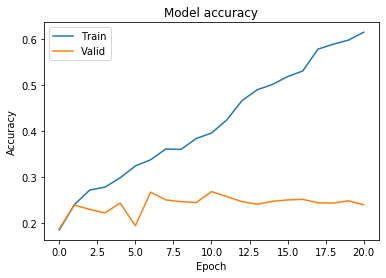

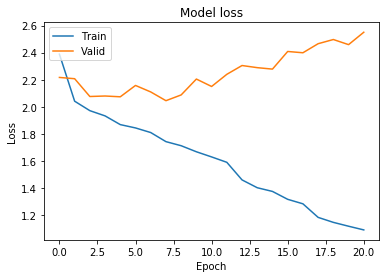

<Figure size 432x288 with 0 Axes>

In [31]:
mlp_model = create_mlp(n_layers=3, n_neurons = np.prod(input_shape)//250)

mlp_3.attach_model(mlp_model)
mlp_3._compile()
mlp_3.summary()
mlp_3.fit(num_epochs=50)
mlp_3.plot_history()

In [32]:
mlp_3.load_model()
mlp_3.summary()
# mlp.evaluate(verbose=1, all=True)
mlp_3.confusion_matrix()
mlp_3.classification_report()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 5568)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5568)              22272     
_________________________________________________________________
hidden_1 (Dense)             (None, 22)                122518    
_________________________________________________________________
hidden_2 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_3 (Dense)             (None, 22)                506       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 184       
Total params: 145,986
Trainable params: 134,850
Non-trainable params: 11,136
___________________________________________

This model also overfits a decent amount. 

### 6 Layers

In [33]:
mlp_path_6 = "models/mlp/mlp_6_layers/"
mlp_6 = MyModel(batch_size=16, model_dir=mlp_path_6)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 5568)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5568)              22272     
_________________________________________________________________
hidden_1 (Dense)             (None, 22)                122518    
_________________________________________________________________
hidden_2 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_3 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_4 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_5 (Dense)             (None, 22)               

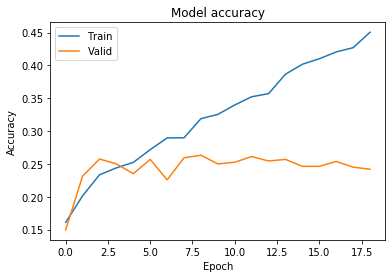

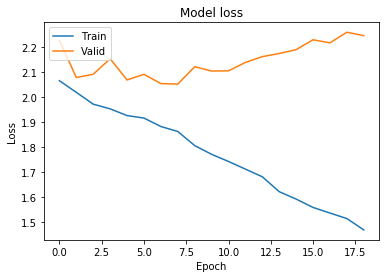

<Figure size 432x288 with 0 Axes>

In [34]:
mlp_model = create_mlp(n_layers=6, n_neurons = np.prod(input_shape)//250)

mlp_6.attach_model(mlp_model)
mlp_6._compile()
mlp_6.summary()
mlp_6.fit(num_epochs=50)
mlp_6.plot_history()

In [35]:
mlp_6.load_model()
mlp_6.summary()
mlp_6.confusion_matrix()
mlp_6.classification_report()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 5568)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5568)              22272     
_________________________________________________________________
hidden_1 (Dense)             (None, 22)                122518    
_________________________________________________________________
hidden_2 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_3 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_4 (Dense)             (None, 22)                506       
_________________________________________________________________
hidden_5 (Dense)             (None, 22)               

Seems to overfit.

## 2D CNN

We explore how well a traditional convolutional neural net works on this dataset.

In [36]:
def create_cnn(num_genres=8, num_filters=20, input_shape=input_shape):
    model = Sequential()
    model.add(
        Conv2D(
            num_filters,
            input_shape=input_shape,
            kernel_size=(4, 4),
            activation="relu",
            #             data_format="channels_first"
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 4)))
    model.add(
        Conv2D(
            num_filters,
            kernel_size=(3, 5),
            activation="relu",
            kernel_regularizer=regularizers.l2(0.0001),
            #             data_format="channels_first"
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(
        Conv2D(
            num_filters,
            kernel_size=(2, 2),
            activation="relu",
            kernel_regularizer=regularizers.l2(0.0001),
            #             data_format="channels_first"
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(num_genres, activation="softmax"))

    return model

In [37]:
conv_net_path = "models/convnet/"
conv_net = MyModel(batch_size=16, model_dir=conv_net_path)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 61, 84, 20)        340       
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 84, 20)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 21, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 17, 20)        6020      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 17, 20)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 8, 20)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 8, 20)        

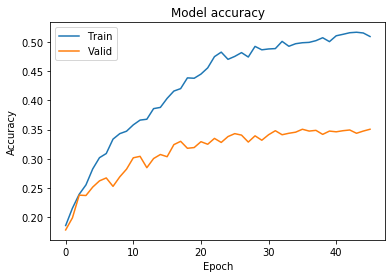

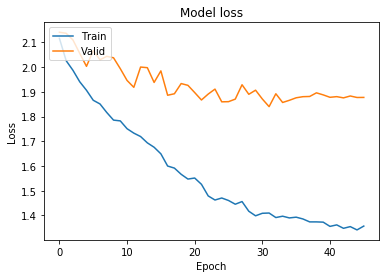

<Figure size 432x288 with 0 Axes>

In [38]:
conv_net_model = create_cnn()

conv_net.attach_model(conv_net_model)
conv_net._compile()
conv_net.summary()
conv_net.fit(num_epochs=50)
conv_net.plot_history()

In [39]:
conv_net.load_model()
conv_net.summary()
conv_net.confusion_matrix()
conv_net.classification_report()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 61, 84, 20)        340       
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 84, 20)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 21, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 17, 20)        6020      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 17, 20)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 8, 20)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 8, 20)        

## CRNN

In [40]:
def create_crnn(
    num_genres=8,
    input_shape=input_shape,
    drop_prob=0.2,
    lstm_count=100,
    n_hidden=64,
    n_layers=4,
    conv_filter_count=64,
):
    model = Sequential()
    model.add(Reshape((input_shape[0], input_shape[1]), input_shape=input_shape))

    # 1D convolutional layers
    for i in range(n_layers):
        model.add(
            Conv1D(
                filters=conv_filter_count,
                kernel_size=4,
                activation="relu",
                kernel_regularizer=regularizers.l2(0.001),
                name="convolution_" + str(i + 1),
            )
        )
        model.add(BatchNormalization(momentum=0.9))
        model.add(MaxPooling1D(2))
        model.add(Dropout(drop_prob))

    # LSTM layer

    model.add(LSTM(lstm_count, return_sequences=False))
    model.add(Dropout(drop_prob))

    # Dense layer
    model.add(Dense(n_hidden, kernel_regularizer=regularizers.l2(0.001), name="dense1"))
    model.add(Dropout(drop_prob))

    # softmax output
    model.add(Dense(num_genres))
    model.add(Activation("softmax", name="output_layer"))

    return model

In [41]:
crnn_path = "models/crnn/"
crnn = MyModel(batch_size=16, model_dir=crnn_path)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 87)            0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, 61, 64)            22336     
_________________________________________________________________
batch_normalization_8 (Batch (None, 61, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, 27, 64)            16448     
_________________________________________________________________
batch_normalization_9 (Batch (None, 27, 64)           

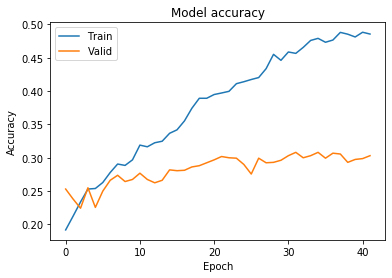

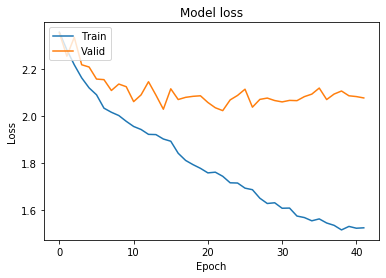

<Figure size 432x288 with 0 Axes>

In [42]:
crnn_model = create_crnn()

crnn.attach_model(crnn_model)
crnn._compile()
crnn.summary()
crnn.fit(num_epochs=50)
crnn.plot_history()

In [43]:
crnn.load_model()
crnn.confusion_matrix()
crnn.classification_report()

[[ 60   0   7  15  15  16  52   0]
 [ 20  15  22  24  44  11  32   2]
 [ 11   6  90  16   7   9   1   2]
 [  8   4  35  87  32  17  28   6]
 [ 10   7  25  20 121   6   7   1]
 [ 10   6  25   8   8  14  11   0]
 [ 36   5  25  18  13  19  92   2]
 [  7   8 131 164  42  17  34  14]]
               precision    recall  f1-score   support

      Hip-Hop       0.37      0.36      0.37       165
          Pop       0.29      0.09      0.14       170
         Folk       0.25      0.63      0.36       142
 Experimental       0.25      0.40      0.31       217
         Rock       0.43      0.61      0.51       197
International       0.13      0.17      0.15        82
   Electronic       0.36      0.44      0.39       210
 Instrumental       0.52      0.03      0.06       417

     accuracy                           0.31      1600
    macro avg       0.32      0.34      0.28      1600
 weighted avg       0.37      0.31      0.26      1600



Probe early layers in network or end results. See which genres get confused.

Remove bias from sampling by sampling at random times.

Ensemble methods if I get a bunch of okay-ish classifiers. 